In [11]:
import os
import time
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from transformers import AutoTokenizer, AutoModel, pipeline
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader, TextLoader, CSVLoader, Docx2txtLoader
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import pytesseract
from PIL import Image
from openpyxl import load_workbook

In [12]:
# Hugging Face Token
HF_TOKEN = "HF_TOKEN"

def upload_files():
    uploaded = files.upload()
    return list(uploaded.keys())

def get_file_paths():
    file_path = input("Enter the full file path: ").strip()
    return [file_path] if os.path.exists(file_path) else []

from openpyxl import load_workbook
import pytesseract
from PIL import Image

def load_documents(file_paths):
    documents = []
    for file in file_paths:
        ext = file.split(".")[-1].lower()
        loader = None  # Initialize loader variable
        if ext == "pdf":
            loader = PyPDFLoader(file)
        elif ext in ["doc", "docx"]:
            loader = Docx2txtLoader(file)
        elif ext == "csv":
            loader = CSVLoader(file, encoding="latin1")  # Handle encoding issues
        elif ext == "txt":
            loader = TextLoader(file)
        elif ext in ["jpg", "jpeg", "png"]:  # OCR for images
            text = pytesseract.image_to_string(Image.open(file))
            documents.append(text)  # Directly append text (not wrapped in dict)
        elif ext == "xlsx":  # Handle Excel files
            wb = load_workbook(file)
            sheet = wb.active
            text = ""
            for row in sheet.iter_rows(values_only=True):
                text += " ".join([str(cell) for cell in row if cell]) + "\n"
            documents.append(text)  # Directly append text (not wrapped in dict)
        else:
            print(f"Unsupported file type: {file}")
            continue

        if loader:  # Only extend if loader is not None
            loaded_docs = loader.load()
            # Ensure all loaded documents are in consistent format
            for doc in loaded_docs:
                documents.append(doc.page_content)  # Directly append the text (not wrapped in dict)

    return documents  # Return a list of texts



In [13]:
# Choose an embedding model
EMBEDDING_MODEL_NAME = "BAAI/bge-large-en"
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME, model_kwargs={"device": "cuda" if torch.cuda.is_available() else "cpu"})
def index_documents(documents):
    if not documents:
        print("No valid text documents found for indexing.")
        return None
    faiss_index = FAISS.from_texts(documents, embedding_model)
    return faiss_index


In [14]:
from transformers import pipeline
from transformers import TextGenerationPipeline, AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import InferenceClient
# Choose a free QA model from Hugging Face
QA_MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"

client = InferenceClient(model=QA_MODEL_NAME, token=HF_TOKEN)

def query_documents(faiss_index, query):
    if faiss_index is None:
        return "No indexed documents available."
    retriever = faiss_index.as_retriever()
    relevant_docs = retriever.get_relevant_documents(query)
    if not relevant_docs:
        return "No relevant information found in the documents."

    context = " ".join([doc.page_content for doc in relevant_docs])
    prompt = f"Based on the following information, answer the question comprehensively:\n\nContext: {context}\n\nQuestion: {query}\n\nAnswer:"

    response = client.text_generation(prompt, max_new_tokens=512)  # Call API instead of downloading
    return response


In [15]:
def evaluate_performance(queries, faiss_index, indexing_time):
    results = []
    for query in queries:
        start_time = time.time()
        response = query_documents(faiss_index, query)
        response_time = time.time() - start_time
        results.append({"Query": query, "Response": response, "Response Time (s)": response_time, "Indexing Time (s)": indexing_time})
    df = pd.DataFrame(results)
    df.to_csv("evaluation_results.csv", index=False)
    print("Evaluation results saved to evaluation_results.csv")
    return df


def visualize_results(df):
    plt.figure(figsize=(10, 5))
    plt.barh(df["Query"], df["Response Time (s)"], color='skyblue')
    plt.xlabel("Response Time (s)")
    plt.ylabel("Query")
    plt.title("Response Time for Queries")
    plt.show()

In [16]:
#!pip install pypdf
#!pip install docx2txt
#!apt-get update
#!apt-get install -y tesseract-ocr
#!pip install pytesseract pillow

Do you want to upload files (U) or provide file paths (P)? p
Enter the full file path: /content/clear_img.jpg
Indexing Time: 2.78 seconds
Enter your query (or type 'exit' to quit): what the image about?
Response:  The image is about the Annual Sports Day - Intramural Schedule.
Enter your query (or type 'exit' to quit): exit
Evaluation results saved to evaluation_results.csv


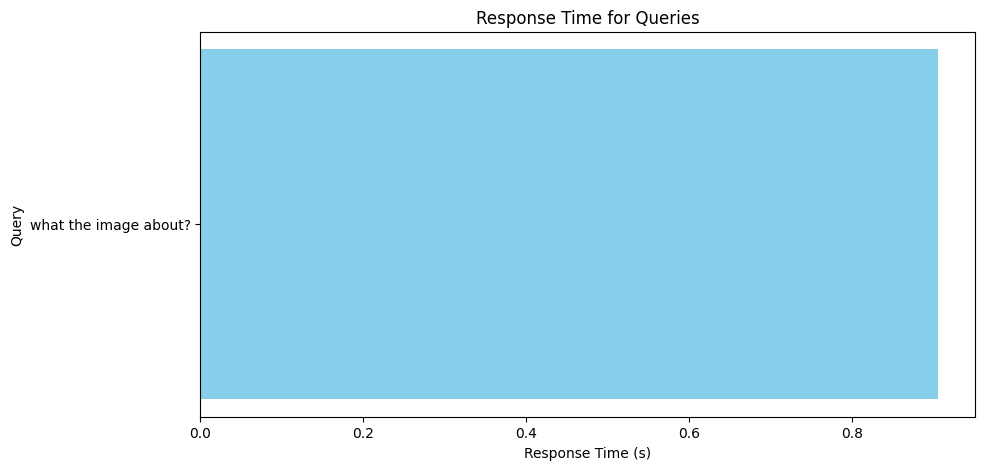

Evaluation results saved to evaluation_results.csv


In [20]:
w# Main Execution
option = input("Do you want to upload files (U) or provide file paths (P)? ").strip().lower()
if option == "u":
    file_list = upload_files()
elif option == "p":
    file_list = get_file_paths()
else:
    print("Invalid option. Exiting...")
    exit()

documents = load_documents(file_list)
start_indexing = time.time()
faiss_index = index_documents(documents)
indexing_time = time.time() - start_indexing
print(f"Indexing Time: {indexing_time:.2f} seconds")

queries = []
while True:
    user_query = input("Enter your query (or type 'exit' to quit): ")
    if user_query.lower() == 'exit':
        break
    queries.append(user_query)
    response = query_documents(faiss_index, user_query)
    print(f"Response: {response}")

evaluation_df = evaluate_performance(queries, faiss_index, indexing_time)
visualize_results(evaluation_df)
print("Evaluation results saved to evaluation_results.csv")